In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow_addons as tfa
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=BadKey)

In [187]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import datasets, layers, models, regularizers


import glob
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Input

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
import tensorflow_addons as tfa
from tensorflow_addons.layers import GroupNormalization

In [158]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat, target_names=['NORMAL', 'PNEUMONIA']))
    print('Recall: ', recall)
    

    plt.plot(fpr, tpr, linestyle='-', label='InceptionResNetV2')
    #plt.plot(fpr, tpr, marker='.')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim(0,1, 20)
    plt.ylim(0,1,30)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    print('ROC-AUC:', roc_auc)
    sns.heatmap(cm,  cmap= 'Greens', annot=True, fmt='d')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

In [6]:
def show_img(train_images, train_labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(train_images[i])
        if train_labels[i]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

In [7]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

#### Data Generators below generate the engineered image sets that do not include train or test images with medical equipment, we still have the originial test set as well for further evaluation.

In [33]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
train_data_sm = train_datagen.flow_from_directory('../data/chest_xray2/train_2/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale')
val_data_sm = val_datagen.flow_from_directory('../data/chest_xray2/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale')
test_data_sm = test_datagen.flow_from_directory('../data/chest_xray2/test_2/',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary',
                                             color_mode='grayscale')

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 427 images belonging to 2 classes.


In [26]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('2nd_model_groupnorm.h5',
                                                  save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                    restore_best_weights=True)

In [ ]:
model2_sm = Sequential()
model2_sm.add(Convolution2D(32, (3,3), input_shape=(100,100,1), activation='relu'))
#Group Normalization Layer
model2_sm.add(GroupNormalization(groups=2, axis=-1))
model2_sm.add(MaxPooling2D(2,2))
model2_sm.add(Flatten())
model2_sm.add(Dense(units=110, activation='relu'))
model2_sm.add(Dense(units=1, activation='sigmoid'))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= 1e-2,
                                                            decay_steps= 20,
                                                            decay_rate= 0.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model2_sm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history2_sm = model2_sm.fit(train_data_sm, epochs=10,  validation_data=(val_data_sm), callbacks=[checkpoint_cb, early_stopping_cb])

In [21]:
first_batch_sm = test_data_sm.next()
data_list = first_batch_sm[0]
batch_index = 0
class_list = first_batch_sm[1]
while batch_index <= test_data_sm.batch_index:
    data = test_data_sm.next()
    #print(data[0].shape)
    data_list=np.concatenate((data_list, data[0]))
    class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
data_array_sm = np.asarray(data_list)
data_array_sm.shape

(422, 100, 100, 1)

              precision    recall  f1-score   support

      NORMAL       0.61      0.45      0.52       229
   PNEUMONIA       0.50      0.66      0.57       193

    accuracy                           0.55       422
   macro avg       0.56      0.55      0.54       422
weighted avg       0.56      0.55      0.54       422

Accurancy:  0.5450236966824644


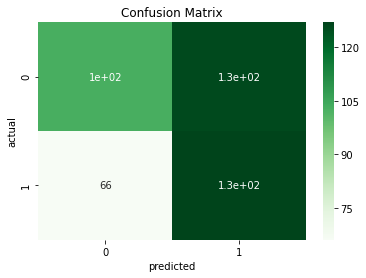

86/86 [==============================] - 4s 43ms/step - loss: 0.6836 - accuracy: 0.5433 - precision: 0.5000 - recall: 0.6564


[('loss', 0.683554470539093),
 ('accuracy', 0.5433255434036255),
 ('precision', 0.5),
 ('recall', 0.656410276889801)]

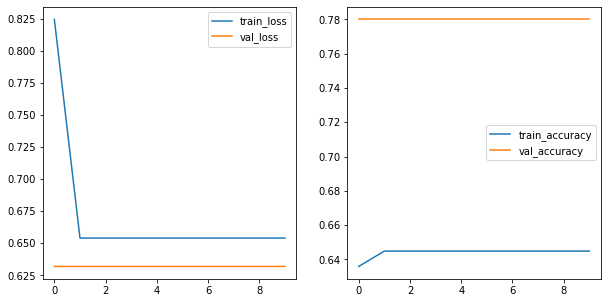

In [24]:
preds2_sm = model2_sm.predict_classes(data_array_sm)
evaluation(class_list, preds2_sm)

train_loss = history2_sm.history['loss']
train_acc = history2_sm.history['accuracy']
val_loss = history2_sm.history['val_loss']
val_acc = history2_sm.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history2_sm.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history2_sm.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history2_sm.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history2_sm.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = model2_sm.evaluate_generator(test_data_sm, steps=len(test_data_sm), verbose=1)
list(zip(model2_sm.metrics_names, acc))

#### New data generators to remove greys scale color mode parameter as well as add a shear range, zoom range, and horizontal flip.

In [136]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225,
                                                               shear_range=0.3,
                                                               zoom_range=0.4,
                                                               horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
transfer_train_data = train_datagen.flow_from_directory('../data/chest_xray2/train_2/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
transfer_val_data = val_datagen.flow_from_directory('../data/chest_xray2/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
transfer_test_data = test_datagen.flow_from_directory('../data/chest_xray2/test_2/',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary')

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 427 images belonging to 2 classes.


#### Validation data generated to evaluate the model using the data from the cell above.

In [137]:
transfer_first_batch = transfer_test_data.next()
transfer_data_list = transfer_first_batch[0]
batch_index = 0
transfer_class_list = transfer_first_batch[1]
while batch_index <= transfer_test_data.batch_index:
    transfer_data = transfer_test_data.next()
    #print(data[0].shape)
    transfer_data_list=np.concatenate((transfer_data_list, transfer_data[0]))
    transfer_class_list=np.concatenate((transfer_class_list, transfer_data[1]))
    batch_index = batch_index + 1
transfer_data_array = np.asarray(transfer_data_list)
transfer_data_array.shape

(427, 100, 100, 3)

#### Instantiating Inception-ResNet-V2

In [76]:
input_shape = Input(shape=(100,100,3))

base_model_inception_res = InceptionResNetV2(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model_inception_res.trainable=False

base_model_inception_res.layers[-1].get_config()

{'name': 'conv_7b_ac',
 'trainable': False,
 'dtype': 'float32',
 'activation': 'relu'}

In [63]:
tr_train_files = glob.glob('../data/chest_xray2/train_2/NORMAL/*'),  glob.glob('../data/chest_xray2/train_2/PNEUMONIA/*')


#### Adding class weights to the model

In [77]:
# NORMAL COUNT
count_normal = len(tr_train_files[0])
count_normal

# PNEUMONIA COUNT
count_pneumonia = len(tr_train_files[1])
count_pneumonia

initial_bias = np.log([count_pneumonia/count_normal])
initial_bias

weight_normal = (1 / count_normal) * (count_normal+count_pneumonia) / 2
weight_pneumonia = (1 / count_pneumonia) * (count_normal+count_pneumonia) / 2
class_weight = {0: weight_normal, 1: weight_pneumonia}
class_weight

{0: 1.1342756183745584, 1: 0.8941504178272981}

#### Adding Exponential Decay to optimizer

In [71]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                            decay_steps=20,
                                                            decay_rate=0.01)


optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)


In [81]:
inception_resnet2 = Sequential([base_model_inception_res,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(90, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 20
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/20
80/80 [==============================] - 27s 334ms/step - loss: 0.5749 - accuracy: 0.7603 - precision: 0.7838 - recall: 0.7273 - val_loss: 0.2175 - val_accuracy: 0.9127 - val_precision: 0.9565 - val_recall: 0.9006
Epoch 2/20
80/80 [==============================] - 25s 311ms/step - loss: 0.3757 - accuracy: 0.8344 - precision: 0.8726 - recall: 0.8246 - val_loss: 0.2115 - val_accuracy: 0.9291 - val_precision: 0.9633 - val_recall: 0.9211
Epoch 3/20
80/80 [==============================] - 27s 332ms/step - loss: 0.3312 - accuracy: 0.8600 - precision: 0.8926 - recall: 0.8530 - val_loss: 0.2018 - val_accuracy: 0.9236 - val_precision: 0.9310 - val_recall: 0.9474
Epoch 4/20
80/80 [==============================] - 29s 366ms/step - loss: 0.3402 - accuracy: 0.8584 - precision: 0.8914 - recall: 0.8505 - val_loss: 0.2136 - val_accuracy: 0.9200 - val_precision: 0.9806 - val_recall: 0.8889
Epoch 5/20
80/80 [==============================] - 28s 354ms/step - loss: 0.3123 - accuracy: 0.8659

              precision    recall  f1-score   support

      NORMAL       0.91      0.82      0.86       232
   PNEUMONIA       0.81      0.91      0.86       195

    accuracy                           0.86       427
   macro avg       0.86      0.86      0.86       427
weighted avg       0.87      0.86      0.86       427

Accurancy:  0.8594847775175644


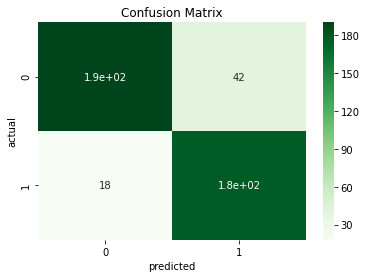

14/14 [==============================] - 12s 876ms/step - loss: 0.3999 - accuracy: 0.8595 - precision: 0.8082 - recall: 0.9077


[('loss', 0.3999156057834625),
 ('accuracy', 0.8594847917556763),
 ('precision', 0.8082191944122314),
 ('recall', 0.9076923131942749)]

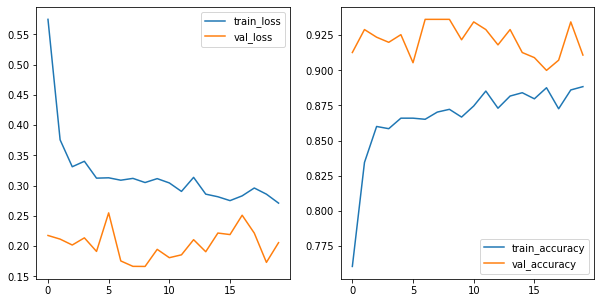

In [82]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

#### Fine tuning the model beginning with layer 750

In [83]:
base_model_inception_res.trainable = True
print('Number of layers in the base model: ', len(base_model_inception_res.layers))

fine_tune = 750
for layer in base_model_inception_res.layers[: fine_tune]:
    layer.trainable = False

In [86]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 20
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/20
80/80 [==============================] - 74s 929ms/step - loss: 0.4039 - accuracy: 0.8364 - precision: 0.8605 - recall: 0.8418 - val_loss: 0.8014 - val_accuracy: 0.8073 - val_precision: 0.9917 - val_recall: 0.6959
Epoch 2/20
80/80 [==============================] - 66s 824ms/step - loss: 0.3318 - accuracy: 0.8616 - precision: 0.9008 - recall: 0.8456 - val_loss: 0.3745 - val_accuracy: 0.8745 - val_precision: 0.9858 - val_recall: 0.8099
Epoch 3/20
80/80 [==============================] - 67s 838ms/step - loss: 0.2992 - accuracy: 0.8762 - precision: 0.9119 - recall: 0.8618 - val_loss: 0.2986 - val_accuracy: 0.9073 - val_precision: 0.9802 - val_recall: 0.8684
Epoch 4/20
80/80 [==============================] - 65s 816ms/step - loss: 0.2861 - accuracy: 0.8864 - precision: 0.9123 - recall: 0.8814 - val_loss: 0.2038 - val_accuracy: 0.9218 - val_precision: 0.9838 - val_recall: 0.8889
Epoch 5/20
80/80 [==============================] - 67s 831ms/step - loss: 0.2638 - accuracy: 0.8912

              precision    recall  f1-score   support

      NORMAL       0.93      0.84      0.88       232
   PNEUMONIA       0.83      0.92      0.88       195

    accuracy                           0.88       427
   macro avg       0.88      0.88      0.88       427
weighted avg       0.89      0.88      0.88       427

Accurancy:  0.8805620608899297


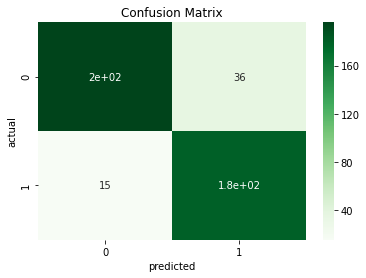

14/14 [==============================] - 5s 368ms/step - loss: 0.3679 - accuracy: 0.8806 - precision: 0.8333 - recall: 0.9231


[('loss', 0.3678506910800934),
 ('accuracy', 0.8805620670318604),
 ('precision', 0.8333333134651184),
 ('recall', 0.9230769276618958)]

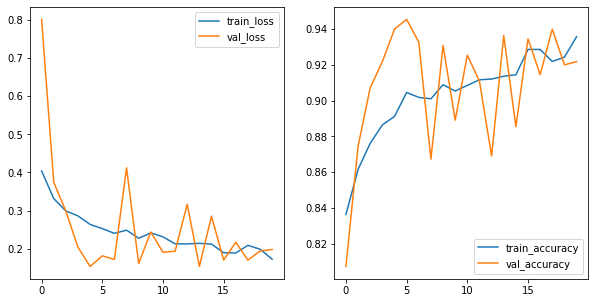

In [87]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

In [88]:
tr_train_files = glob.glob('../data/chest_xray2/val/NORMAL/*'),  glob.glob('../data/chest_xray2/val/PNEUMONIA/*')
tr_val_files = glob.glob('../data/chest_xray2/val/NORMAL/*'),  glob.glob('../data/chest_xray2/val/PNEUMONIA/*')


#### Adding class weights by difference in x-rays in both training and validation datasets

In [89]:
count_normal = len(tr_train_files[0]) + len(tr_val_files[0])
count_normal

count_pneumonia = len(tr_train_files[1]) + len(tr_val_files[1])
count_pneumonia

initial_bias = np.log([count_pneumonia/count_normal])
initial_bias

array([0.49727266])

In [90]:
weight_normal = (1 / count_normal) * (count_normal+count_pneumonia) / 2
weight_pneumonia = (1 / count_pneumonia) * (count_normal+count_pneumonia) / 2
class_weight = {0: weight_normal, 1: weight_pneumonia}
class_weight

{0: 1.3221153846153846, 1: 0.804093567251462}

In [160]:
c_back = tf.keras.callbacks.EarlyStopping(patience=13, restore_best_weights=True)

In [128]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 50
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  callbacks=c_back,
                  validation_data=transfer_val_data)

Epoch 1/50
80/80 [==============================] - 37s 460ms/step - loss: 0.1589 - accuracy: 0.9405 - precision: 0.9445 - recall: 0.9316 - val_loss: 0.2201 - val_accuracy: 0.9273 - val_precision: 0.9748 - val_recall: 0.9064
Epoch 2/50
80/80 [==============================] - 35s 434ms/step - loss: 0.1600 - accuracy: 0.9416 - precision: 0.9677 - recall: 0.9269 - val_loss: 0.1902 - val_accuracy: 0.9291 - val_precision: 0.9605 - val_recall: 0.9240
Epoch 3/50
80/80 [==============================] - 38s 474ms/step - loss: 0.1591 - accuracy: 0.9393 - precision: 0.9619 - recall: 0.9280 - val_loss: 0.2304 - val_accuracy: 0.9273 - val_precision: 0.9548 - val_recall: 0.9269
Epoch 4/50
80/80 [==============================] - 38s 470ms/step - loss: 0.1462 - accuracy: 0.9436 - precision: 0.9576 - recall: 0.9408 - val_loss: 0.1692 - val_accuracy: 0.9418 - val_precision: 0.9697 - val_recall: 0.9357
Epoch 5/50
80/80 [==============================] - 37s 463ms/step - loss: 0.1425 - accuracy: 0.9472

              precision    recall  f1-score   support

      NORMAL       0.95      0.84      0.89       232
   PNEUMONIA       0.84      0.94      0.89       195

    accuracy                           0.89       427
   macro avg       0.89      0.89      0.89       427
weighted avg       0.90      0.89      0.89       427

Accurancy:  0.8899297423887588


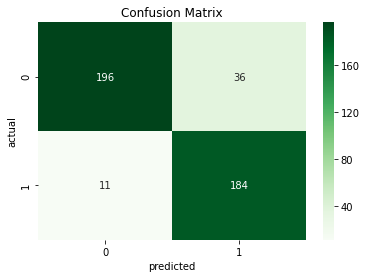

14/14 [==============================] - 5s 356ms/step - loss: 0.3626 - accuracy: 0.8899 - precision: 0.8364 - recall: 0.9436


[('loss', 0.36264967918395996),
 ('accuracy', 0.8899297714233398),
 ('precision', 0.8363636136054993),
 ('recall', 0.9435897469520569)]

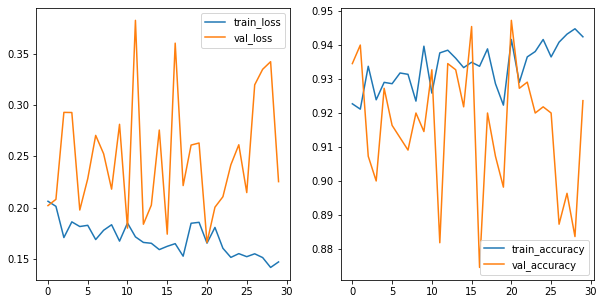

In [97]:

inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

In [102]:
mets = list(zip(inception_resnet2.metrics_names, acc))

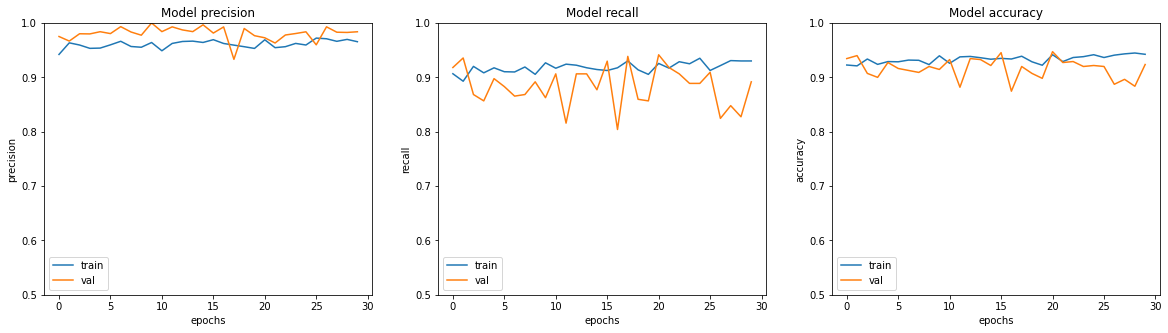

In [115]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy']):
    ax[i].plot(inception_resnet2_history.history[met])
    ax[i].plot(inception_resnet2_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].set_ylim(0.5,1)
    ax[i].legend(['train', 'val'])

In [116]:
from sklearn.metrics import roc_curve, auc

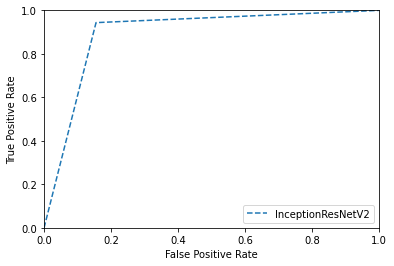

In [126]:
fpr, tpr, thresholds = roc_curve(transfer_class_list, inception_resnet2_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, linestyle='--', label='InceptionResNetV2')
#plt.plot(fpr, tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1, 20)
plt.ylim(0,1,30)
# show the legend
plt.legend()
# show the plot
plt.show()

In [127]:
roc_auc

0.8942086648983201

#### Fine tuning the model beginning with layer 600

In [133]:
base_model_inception_res.trainable = True
print('Number of layers in the base model: ', len(base_model_inception_res.layers))

fine_tune = 600
for layer in base_model_inception_res.layers[: fine_tune]:
    layer.trainable = False

Number of layers in the base model:  780


In [138]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 50
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  callbacks=c_back,
                  validation_data=transfer_val_data)

Epoch 1/50
80/80 [==============================] - 43s 540ms/step - loss: 0.2044 - accuracy: 0.9203 - precision: 0.9330 - recall: 0.9300 - val_loss: 1.8418 - val_accuracy: 0.9491 - val_precision: 0.9816 - val_recall: 0.9357
Epoch 2/50
80/80 [==============================] - 41s 519ms/step - loss: 0.1628 - accuracy: 0.9322 - precision: 0.9476 - recall: 0.9303 - val_loss: 0.2431 - val_accuracy: 0.9127 - val_precision: 0.9868 - val_recall: 0.8713
Epoch 3/50
80/80 [==============================] - 42s 528ms/step - loss: 0.1770 - accuracy: 0.9298 - precision: 0.9395 - recall: 0.9342 - val_loss: 0.2322 - val_accuracy: 0.9000 - val_precision: 0.9898 - val_recall: 0.8480
Epoch 4/50
80/80 [==============================] - 44s 548ms/step - loss: 0.1919 - accuracy: 0.9243 - precision: 0.9310 - recall: 0.9337 - val_loss: 0.1837 - val_accuracy: 0.9400 - val_precision: 0.9874 - val_recall: 0.9152
Epoch 5/50
80/80 [==============================] - 42s 526ms/step - loss: 0.1895 - accuracy: 0.9105

              precision    recall  f1-score   support

      NORMAL       0.96      0.88      0.91       232
   PNEUMONIA       0.87      0.95      0.91       195

    accuracy                           0.91       427
   macro avg       0.91      0.91      0.91       427
weighted avg       0.92      0.91      0.91       427

Accurancy:  0.9110070257611241


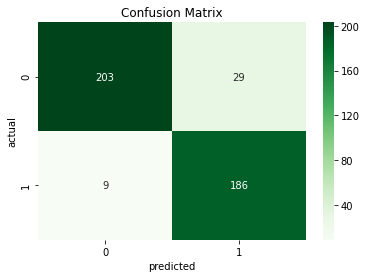

14/14 [==============================] - 5s 391ms/step - loss: 0.2780 - accuracy: 0.9110 - precision: 0.8651 - recall: 0.9538


[('loss', 0.2779882550239563),
 ('accuracy', 0.9110070466995239),
 ('precision', 0.8651162981987),
 ('recall', 0.9538461565971375)]

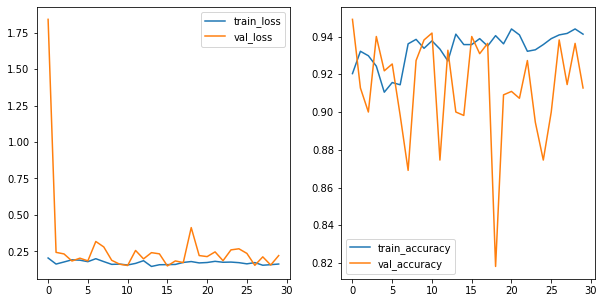

In [140]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

#### Adding early callback to focus on recall score

In [141]:
c_back = tf.keras.callbacks.EarlyStopping(patience=16, restore_best_weights=True, monitor='recall')

In [142]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 50
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  callbacks=c_back,
                  validation_data=transfer_val_data)

Epoch 1/50
80/80 [==============================] - 43s 535ms/step - loss: 0.1733 - accuracy: 0.9267 - precision: 0.9560 - recall: 0.9027 - val_loss: 0.3019 - val_accuracy: 0.8636 - val_precision: 1.0000 - val_recall: 0.7807
Epoch 2/50
80/80 [==============================] - 41s 518ms/step - loss: 0.1701 - accuracy: 0.9251 - precision: 0.9637 - recall: 0.8998 - val_loss: 0.2379 - val_accuracy: 0.8964 - val_precision: 1.0000 - val_recall: 0.8333
Epoch 3/50
80/80 [==============================] - 42s 523ms/step - loss: 0.1640 - accuracy: 0.9361 - precision: 0.9673 - recall: 0.9169 - val_loss: 0.1518 - val_accuracy: 0.9491 - val_precision: 0.9906 - val_recall: 0.9269
Epoch 4/50
80/80 [==============================] - 43s 532ms/step - loss: 0.1639 - accuracy: 0.9409 - precision: 0.9681 - recall: 0.9243 - val_loss: 0.1829 - val_accuracy: 0.9309 - val_precision: 0.9935 - val_recall: 0.8947
Epoch 5/50
80/80 [==============================] - 42s 530ms/step - loss: 0.1739 - accuracy: 0.9353

              precision    recall  f1-score   support

      NORMAL       0.91      0.90      0.90       232
   PNEUMONIA       0.88      0.89      0.89       195

    accuracy                           0.89       427
   macro avg       0.89      0.89      0.89       427
weighted avg       0.89      0.89      0.89       427

Accurancy:  0.8946135831381733


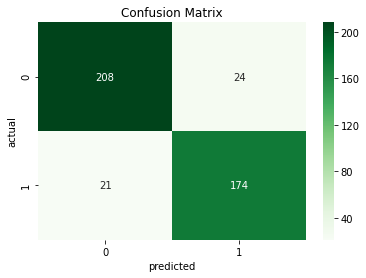

14/14 [==============================] - 5s 374ms/step - loss: 0.4218 - accuracy: 0.8946 - precision: 0.8788 - recall: 0.8923


[('loss', 0.42184752225875854),
 ('accuracy', 0.8946135640144348),
 ('precision', 0.8787878751754761),
 ('recall', 0.892307698726654)]

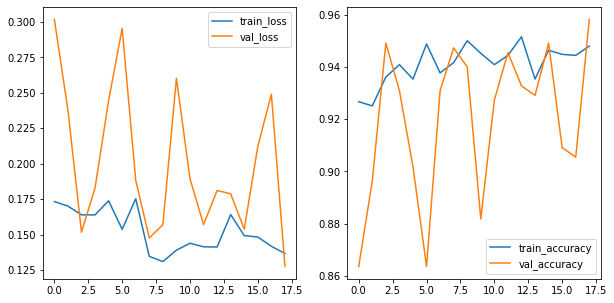

In [143]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

#### Fine Tuning iteration from layer 635

In [144]:
base_model_inception_res.trainable = True
print('Number of layers in the base model: ', len(base_model_inception_res.layers))

fine_tune = 635
for layer in base_model_inception_res.layers[: fine_tune]:
    layer.trainable = False

Number of layers in the base model:  780


In [145]:
c_back = tf.keras.callbacks.EarlyStopping(patience=16, restore_best_weights=True)

In [146]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 50
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  callbacks=c_back,
                  validation_data=transfer_val_data)

Epoch 1/50
80/80 [==============================] - 42s 520ms/step - loss: 0.1680 - accuracy: 0.9314 - precision: 0.9604 - recall: 0.9015 - val_loss: 0.1686 - val_accuracy: 0.9345 - val_precision: 0.9935 - val_recall: 0.9006
Epoch 2/50
80/80 [==============================] - 40s 496ms/step - loss: 0.1687 - accuracy: 0.9326 - precision: 0.9636 - recall: 0.9141 - val_loss: 0.2215 - val_accuracy: 0.9091 - val_precision: 0.9966 - val_recall: 0.8567
Epoch 3/50
80/80 [==============================] - 41s 515ms/step - loss: 0.1719 - accuracy: 0.9345 - precision: 0.9624 - recall: 0.9191 - val_loss: 0.2054 - val_accuracy: 0.9273 - val_precision: 0.9935 - val_recall: 0.8889
Epoch 4/50
80/80 [==============================] - 41s 510ms/step - loss: 0.1506 - accuracy: 0.9412 - precision: 0.9681 - recall: 0.9250 - val_loss: 0.1730 - val_accuracy: 0.9491 - val_precision: 0.9876 - val_recall: 0.9298
Epoch 5/50
80/80 [==============================] - 41s 507ms/step - loss: 0.1901 - accuracy: 0.9164

              precision    recall  f1-score   support

      NORMAL       0.96      0.84      0.90       232
   PNEUMONIA       0.83      0.96      0.89       195

    accuracy                           0.89       427
   macro avg       0.90      0.90      0.89       427
weighted avg       0.90      0.89      0.89       427

Accurancy:  0.8946135831381733


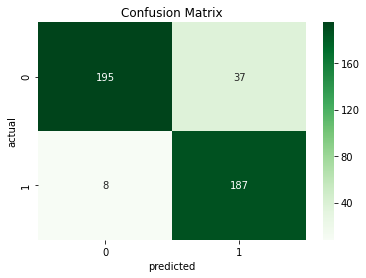

14/14 [==============================] - 5s 378ms/step - loss: 0.2944 - accuracy: 0.8946 - precision: 0.8348 - recall: 0.9590


[('loss', 0.29443687200546265),
 ('accuracy', 0.8946135640144348),
 ('precision', 0.8348214030265808),
 ('recall', 0.9589743614196777)]

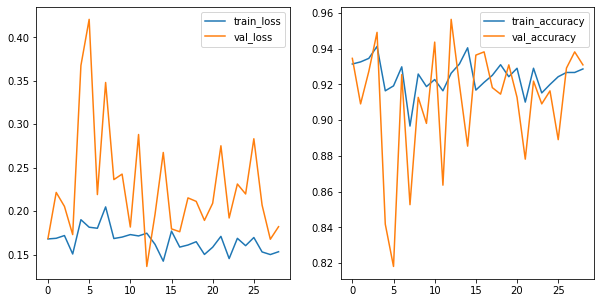

In [147]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

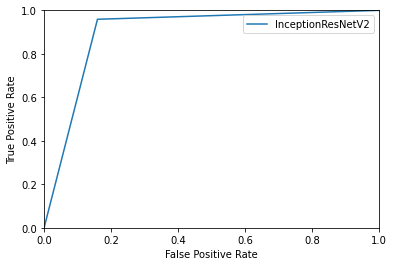

0.8997458001768347


In [149]:
fpr, tpr, thresholds = roc_curve(transfer_class_list, inception_resnet2_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, linestyle='-', label='InceptionResNetV2')
#plt.plot(fpr, tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1, 20)
plt.ylim(0,1,30)
# show the legend
plt.legend()
# show the plot
plt.show()
print(roc_auc)

In [161]:
base_model_inception_res.trainable = True
print('Number of layers in the base model: ', len(base_model_inception_res.layers))

fine_tune = 600
for layer in base_model_inception_res.layers[: fine_tune]:
    layer.trainable = False

Number of layers in the base model:  780


In [202]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model', save_best_only=True)
c_back = tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True)

In [205]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 20
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/20
80/80 [==============================] - 48s 604ms/step - loss: 0.1136 - accuracy: 0.9578 - precision: 0.9748 - recall: 0.9438 - val_loss: 0.1670 - val_accuracy: 0.9382 - val_precision: 0.9904 - val_recall: 0.9094
Epoch 2/20
80/80 [==============================] - 47s 587ms/step - loss: 0.1219 - accuracy: 0.9610 - precision: 0.9761 - recall: 0.9534 - val_loss: 0.1447 - val_accuracy: 0.9473 - val_precision: 0.9906 - val_recall: 0.9240
Epoch 3/20
80/80 [==============================] - 47s 592ms/step - loss: 0.1184 - accuracy: 0.9578 - precision: 0.9746 - recall: 0.9492 - val_loss: 0.2094 - val_accuracy: 0.9200 - val_precision: 0.9901 - val_recall: 0.8801
Epoch 4/20
80/80 [==============================] - 47s 588ms/step - loss: 0.1150 - accuracy: 0.9554 - precision: 0.9725 - recall: 0.9471 - val_loss: 0.1673 - val_accuracy: 0.9345 - val_precision: 0.9935 - val_recall: 0.9006
Epoch 5/20
80/80 [==============================] - 48s 595ms/step - loss: 0.1013 - accuracy: 0.9618

              precision    recall  f1-score   support

      NORMAL       0.97      0.85      0.91       232
   PNEUMONIA       0.85      0.96      0.90       195

    accuracy                           0.90       427
   macro avg       0.91      0.91      0.90       427
weighted avg       0.91      0.90      0.90       427

Recall:  0.9641025641025641


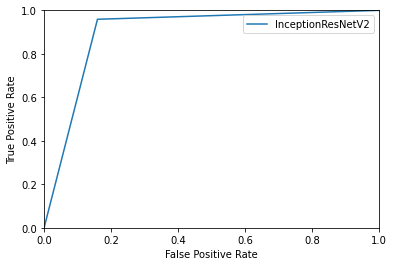

ROC-AUC: 0.8997458001768347


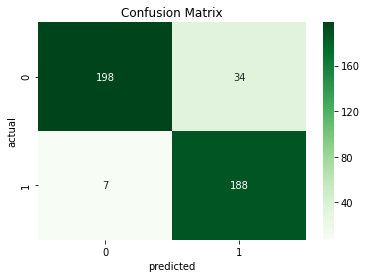

14/14 [==============================] - 5s 386ms/step - loss: 0.2996 - accuracy: 0.9040 - precision: 0.8468 - recall: 0.9641


[('loss', 0.2995607852935791),
 ('accuracy', 0.9039812684059143),
 ('precision', 0.8468468189239502),
 ('recall', 0.964102566242218)]

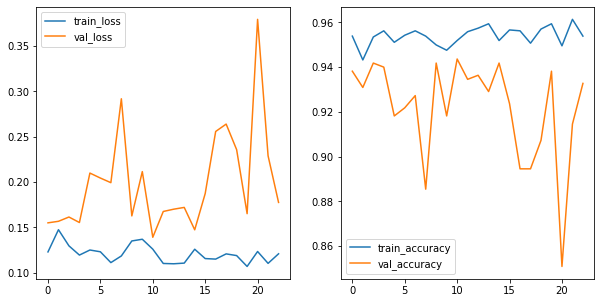

In [182]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

#### Same model but increasing shear and zoom range for training images

In [194]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225,
                                                               shear_range=0.3,
                                                               zoom_range=0.4,
                                                               horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
transfer_train_data = train_datagen.flow_from_directory('../data/chest_xray2/train_2/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
transfer_val_data = val_datagen.flow_from_directory('../data/chest_xray2/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
transfer_test_data = test_datagen.flow_from_directory('../data/chest_xray/test/',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary')

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [195]:
transfer_first_batch = transfer_test_data.next()
transfer_data_list = transfer_first_batch[0]
batch_index = 0
transfer_class_list = transfer_first_batch[1]
while batch_index <= transfer_test_data.batch_index:
    transfer_data = transfer_test_data.next()
    #print(data[0].shape)
    transfer_data_list=np.concatenate((transfer_data_list, transfer_data[0]))
    transfer_class_list=np.concatenate((transfer_class_list, transfer_data[1]))
    batch_index = batch_index + 1
transfer_data_array = np.asarray(transfer_data_list)
transfer_data_array.shape

(624, 100, 100, 3)

              precision    recall  f1-score   support

      NORMAL       0.95      0.85      0.90       234
   PNEUMONIA       0.92      0.97      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624

Recall:  0.9743589743589743


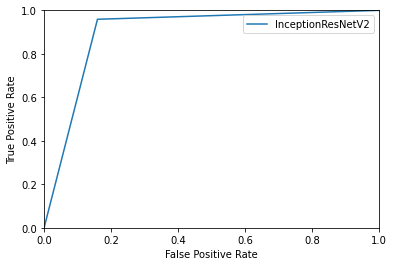

ROC-AUC: 0.8997458001768347


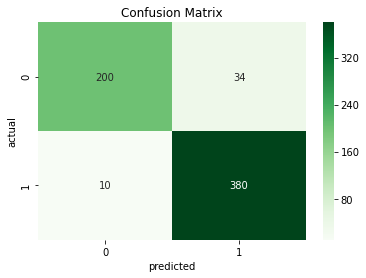

20/20 [==============================] - 6s 318ms/step - loss: 0.2197 - accuracy: 0.9295 - precision: 0.9179 - recall: 0.9744


[('loss', 0.21972163021564484),
 ('accuracy', 0.9294871687889099),
 ('precision', 0.9178743958473206),
 ('recall', 0.9743589758872986)]

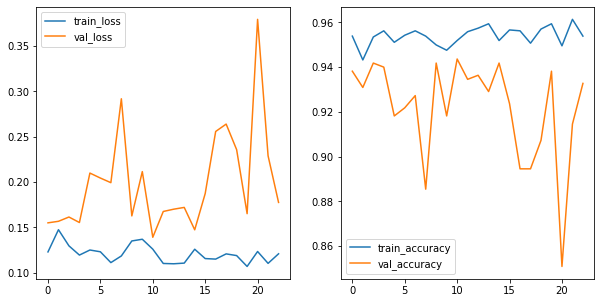

In [196]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))